# MIA attacks on Length-of-Stay predictor, Gated Recurrent Unit with Decay (GRU-D), with DPSGD
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables
conda install -c conda-forge opacus

In [2]:
import os
import sys

from torch import zeros

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from utils.data_processing import get_mimic_dataloaders, get_mimic_dataset

/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


The  `batch_size` is one of the parameters which is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [3]:
# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), "data/")

train_frac = 0.4
valid_frac = 0.0
test_frac = 0.0
early_stop_frac = 0.4
batch_size = 74
use_LR = False # True if you want to use the LR model, False if you want to use the GRUD model

dataset, train_indices, validation_indices, test_indices, early_stop_indices= get_mimic_dataset(path,
                                                                            train_frac ,
                                                                            valid_frac,
                                                                            test_frac,
                                                                            early_stop_frac,
                                                                            use_LR)

Loading dataset...
Loaded dataset from /home/fazeleh/LeakPro/examples/mia/LOS/data/GRUD_data/dataset.pkl


In [4]:
train_loader, validation_loader, test_loader, early_stop_loader = get_mimic_dataloaders(dataset,
                                                            train_indices,
                                                            validation_indices,
                                                            test_indices,
                                                            early_stop_indices,
                                                            batch_size)

In [5]:
target_model_dir = "./target_GRUD_dpsgd"
# epsilons = [.0001, .001, .01, .1, .5, 1, 2, 3.5, 5, 7, 10] # epsilons to run over
delta = 1e-5
target_epsilon = 3.5
sample_rate = 1/len(train_loader) # already incorporates batchsize

In [6]:
noise_multiplier_dict = {
    "target_epsilon": target_epsilon,
    "target_delta": delta,
    "sample_rate": sample_rate,
    "epochs": 21,
    "epsilon_tolerance": 0.01,
    "accountant": "prv",
    "eps_error": 0.01,
    "max_grad_norm": 1,
}


The `optimized_hyperparams` is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [12]:
optimized_hyperparams ={
    "hidden_size": 27,
    "learning_rate": 0.000289,
    "num_epochs":40,
    "patience_early_stopping": 40,
    "patience_lr_scheduler": 2,
    "batch_size": 74,
    "seed": 6286,
    "min_delta": 0.00001,
    }

n_features = int(dataset.x.shape[1]/3)
X_mean = zeros(1,dataset.x.shape[2],n_features)

# Add other required parameters to model_params
model_params = {
    "hidden_size": optimized_hyperparams["hidden_size"],
    "batch_size": optimized_hyperparams["batch_size"],
    "input_size": n_features,
    "X_mean": X_mean,
    "output_last": False,
    "bn_flag": False,
}

In [13]:
# import warnings
# warnings.simplefilter("ignore", category=FutureWarning)
from utils.model_GRUD_dpsgd import *


# Initialize the model with filtered parameters
model = GRUD_DPSGD(**model_params)
# Train the model
results= dpsgd_gru_trained_model_and_metadata(
                                            model,
                                            train_loader,
                                            early_stop_loader,
                                            noise_multiplier_dict,
                                            epochs=optimized_hyperparams["num_epochs"],
                                            patience_early_stopping = optimized_hyperparams["patience_early_stopping"],
                                            patience_lr= optimized_hyperparams["patience_lr_scheduler"],
                                            min_delta = optimized_hyperparams["min_delta"],
                                            learning_rate = optimized_hyperparams["learning_rate"],
                                            target_model_dir = target_model_dir,)
train_losses, test_losses , train_acc, test_acc, best_model, privacy_engine  = results

Model Structure:  GRUD_DPSGD(
  (zl): Linear(in_features=235, out_features=27, bias=True)
  (rl): Linear(in_features=235, out_features=27, bias=True)
  (hl): Linear(in_features=235, out_features=27, bias=True)
  (gamma_x_l): FilterLinear(in_features=104, out_features=104, bias=True)
  (gamma_h_l): Linear(in_features=104, out_features=27, bias=True)
  (fc): Linear(in_features=27, out_features=1, bias=True)
  (drop): Dropout(p=0.57, inplace=False)
)
Start Training ... 
Output type dermined by the model


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
Training Progress:   0%|          | 0/40 [00:00<?, ?it/s]/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_h

Epoch 0: Validation loss improved to 0.6690
Learning Rate: 0.000289000000
Epoch: 0, train_loss: 0.68186917, valid_loss: 0.66900224


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:   5%|▌         | 2/40 [00:20<06:36, 10.44s/it]

Epoch 1: Validation loss improved to 0.6536
Learning Rate: 0.000289000000
Epoch: 1, train_loss: 0.66348555, valid_loss: 0.65363472


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:   8%|▊         | 3/40 [00:31<06:24, 10.40s/it]

Epoch 2: Validation loss improved to 0.6496
Learning Rate: 0.000289000000
Epoch: 2, train_loss: 0.66181733, valid_loss: 0.64959982


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  10%|█         | 4/40 [00:41<06:12, 10.35s/it]

Epoch 3: No improvement. Patience counter: 1/40
Learning Rate: 0.000289000000
Epoch: 3, train_loss: 0.66714548, valid_loss: 0.66021701


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  12%|█▎        | 5/40 [00:51<06:01, 10.33s/it]

Epoch 4: No improvement. Patience counter: 2/40
Learning Rate: 0.000289000000
Epoch: 4, train_loss: 0.69054931, valid_loss: 0.69051211


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  15%|█▌        | 6/40 [01:02<05:50, 10.32s/it]

Epoch 5: No improvement. Patience counter: 3/40
Learning Rate: 0.000057800000
Epoch: 5, train_loss: 0.7377677, valid_loss: 0.72886031


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  18%|█▊        | 7/40 [01:12<05:40, 10.32s/it]

Epoch 6: No improvement. Patience counter: 4/40
Learning Rate: 0.000057800000
Epoch: 6, train_loss: 0.74420505, valid_loss: 0.73655792


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  20%|██        | 8/40 [01:22<05:30, 10.32s/it]

Epoch 7: No improvement. Patience counter: 5/40
Learning Rate: 0.000057800000
Epoch: 7, train_loss: 0.7309282, valid_loss: 0.74567917


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  22%|██▎       | 9/40 [01:33<05:21, 10.36s/it]

Epoch 8: No improvement. Patience counter: 6/40
Learning Rate: 0.000011560000
Epoch: 8, train_loss: 0.75350802, valid_loss: 0.75328852


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  25%|██▌       | 10/40 [01:43<05:12, 10.41s/it]

Epoch 9: No improvement. Patience counter: 7/40
Learning Rate: 0.000011560000
Epoch: 9, train_loss: 0.77744571, valid_loss: 0.75478407


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  28%|██▊       | 11/40 [01:54<05:02, 10.42s/it]

Epoch 10: No improvement. Patience counter: 8/40
Learning Rate: 0.000011560000
Epoch: 10, train_loss: 0.77874301, valid_loss: 0.75618432


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  30%|███       | 12/40 [02:04<04:51, 10.42s/it]

Epoch 11: No improvement. Patience counter: 9/40
Learning Rate: 0.000002312000
Epoch: 11, train_loss: 0.7627925, valid_loss: 0.75781476


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  32%|███▎      | 13/40 [02:14<04:40, 10.40s/it]

Epoch 12: No improvement. Patience counter: 10/40
Learning Rate: 0.000002312000
Epoch: 12, train_loss: 0.77805941, valid_loss: 0.75808825


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  35%|███▌      | 14/40 [02:25<04:29, 10.38s/it]

Epoch 13: No improvement. Patience counter: 11/40
Learning Rate: 0.000002312000
Epoch: 13, train_loss: 0.77715948, valid_loss: 0.75838204


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  38%|███▊      | 15/40 [02:35<04:19, 10.38s/it]

Epoch 14: No improvement. Patience counter: 12/40
Learning Rate: 0.000000462400
Epoch: 14, train_loss: 0.77876498, valid_loss: 0.75865256


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  40%|████      | 16/40 [02:45<04:08, 10.36s/it]

Epoch 15: No improvement. Patience counter: 13/40
Learning Rate: 0.000000462400
Epoch: 15, train_loss: 0.77903966, valid_loss: 0.75871266


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  42%|████▎     | 17/40 [02:56<03:57, 10.34s/it]

Epoch 16: No improvement. Patience counter: 14/40
Learning Rate: 0.000000462400
Epoch: 16, train_loss: 0.78404308, valid_loss: 0.75876537


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  45%|████▌     | 18/40 [03:06<03:45, 10.26s/it]

Epoch 17: No improvement. Patience counter: 15/40
Learning Rate: 0.000000092480
Epoch: 17, train_loss: 0.7617233, valid_loss: 0.75882434


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  48%|████▊     | 19/40 [03:16<03:33, 10.16s/it]

Epoch 18: No improvement. Patience counter: 16/40
Learning Rate: 0.000000092480
Epoch: 18, train_loss: 0.77998997, valid_loss: 0.75883689


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  50%|█████     | 20/40 [03:26<03:22, 10.14s/it]

Epoch 19: No improvement. Patience counter: 17/40
Learning Rate: 0.000000092480
Epoch: 19, train_loss: 0.77044112, valid_loss: 0.75885029


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  52%|█████▎    | 21/40 [03:36<03:11, 10.10s/it]

Epoch 20: No improvement. Patience counter: 18/40
Learning Rate: 0.000000018496
Epoch: 20, train_loss: 0.77682866, valid_loss: 0.75886279


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  55%|█████▌    | 22/40 [03:46<03:04, 10.23s/it]

Epoch 21: No improvement. Patience counter: 19/40
Learning Rate: 0.000000018496
Epoch: 21, train_loss: 0.78172943, valid_loss: 0.75886433


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  57%|█████▊    | 23/40 [03:57<02:55, 10.31s/it]

Epoch 22: No improvement. Patience counter: 20/40
Learning Rate: 0.000000018496
Epoch: 22, train_loss: 0.76860743, valid_loss: 0.75886607


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  60%|██████    | 24/40 [04:07<02:45, 10.33s/it]

Epoch 23: No improvement. Patience counter: 21/40
Learning Rate: 0.000000003699
Epoch: 23, train_loss: 0.77965448, valid_loss: 0.7588676


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  62%|██████▎   | 25/40 [04:17<02:33, 10.25s/it]

Epoch 24: No improvement. Patience counter: 22/40
Learning Rate: 0.000000003699
Epoch: 24, train_loss: 0.78305232, valid_loss: 0.75886766


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  65%|██████▌   | 26/40 [04:27<02:23, 10.22s/it]

Epoch 25: No improvement. Patience counter: 23/40
Learning Rate: 0.000000003699
Epoch: 25, train_loss: 0.7784175, valid_loss: 0.75886774


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  68%|██████▊   | 27/40 [04:37<02:11, 10.14s/it]

Epoch 26: No improvement. Patience counter: 24/40
Learning Rate: 0.000000003699
Epoch: 26, train_loss: 0.77390163, valid_loss: 0.75886784


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  70%|███████   | 28/40 [04:47<02:01, 10.09s/it]

Epoch 27: No improvement. Patience counter: 25/40
Learning Rate: 0.000000003699
Epoch: 27, train_loss: 0.77883858, valid_loss: 0.75886792


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  72%|███████▎  | 29/40 [04:57<01:50, 10.05s/it]

Epoch 28: No improvement. Patience counter: 26/40
Learning Rate: 0.000000003699
Epoch: 28, train_loss: 0.77093056, valid_loss: 0.75886803


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  75%|███████▌  | 30/40 [05:07<01:40, 10.02s/it]

Epoch 29: No improvement. Patience counter: 27/40
Learning Rate: 0.000000003699
Epoch: 29, train_loss: 0.76761183, valid_loss: 0.75886815


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  78%|███████▊  | 31/40 [05:17<01:29, 10.00s/it]

Epoch 30: No improvement. Patience counter: 28/40
Learning Rate: 0.000000003699
Epoch: 30, train_loss: 0.79176948, valid_loss: 0.75886826


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  80%|████████  | 32/40 [05:27<01:19,  9.98s/it]

Epoch 31: No improvement. Patience counter: 29/40
Learning Rate: 0.000000003699
Epoch: 31, train_loss: 0.7821053, valid_loss: 0.75886832


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  82%|████████▎ | 33/40 [05:37<01:10, 10.07s/it]

Epoch 32: No improvement. Patience counter: 30/40
Learning Rate: 0.000000003699
Epoch: 32, train_loss: 0.76786015, valid_loss: 0.75886843


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  85%|████████▌ | 34/40 [05:49<01:03, 10.61s/it]

Epoch 33: No improvement. Patience counter: 31/40
Learning Rate: 0.000000003699
Epoch: 33, train_loss: 0.79186044, valid_loss: 0.75886853


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  88%|████████▊ | 35/40 [06:01<00:54, 10.92s/it]

Epoch 34: No improvement. Patience counter: 32/40
Learning Rate: 0.000000003699
Epoch: 34, train_loss: 0.79216384, valid_loss: 0.7588686


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  90%|█████████ | 36/40 [06:13<00:44, 11.16s/it]

Epoch 35: No improvement. Patience counter: 33/40
Learning Rate: 0.000000003699
Epoch: 35, train_loss: 0.78572626, valid_loss: 0.75886868


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  92%|█████████▎| 37/40 [06:24<00:33, 11.30s/it]

Epoch 36: No improvement. Patience counter: 34/40
Learning Rate: 0.000000003699
Epoch: 36, train_loss: 0.7828928, valid_loss: 0.75886879


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  95%|█████████▌| 38/40 [06:36<00:22, 11.41s/it]

Epoch 37: No improvement. Patience counter: 35/40
Learning Rate: 0.000000003699
Epoch: 37, train_loss: 0.78249492, valid_loss: 0.75886888


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  98%|█████████▊| 39/40 [06:48<00:11, 11.46s/it]

Epoch 38: No improvement. Patience counter: 36/40
Learning Rate: 0.000000003699
Epoch: 38, train_loss: 0.78240547, valid_loss: 0.75886898


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


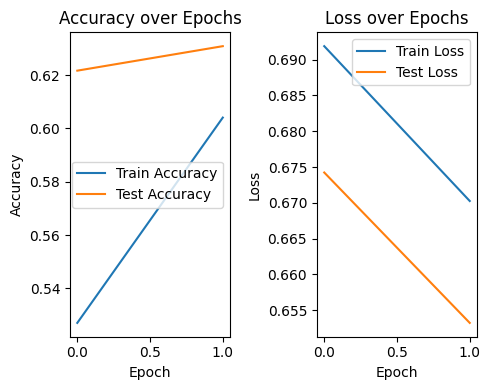

In [9]:
import matplotlib.pyplot as plt

# Convert losses to numpy-compatible lists directly
train_losses_cpu = [float(loss) for loss in train_losses]
test_losses_cpu = [float(loss) for loss in test_losses]

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# from mimic_GRUD_handler import MimicInputHandlerGRU
from mimic_GRUD_dpsgd_handler import MimicInputHandlerGRUdpsgd

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(MimicInputHandlerGRUdpsgd, config_path)

# Run the audit
mia_results = leakpro.run_audit(return_results=True)

2025-03-03 17:50:57,568 INFO     Target model blueprint created from GRUD_DPSGD in utils/model_GRUD_dpsgd.py.
03/03/2025 17:50:57:INFO:Target model blueprint created from GRUD_DPSGD in utils/model_GRUD_dpsgd.py.


2025-03-03 17:50:57,606 INFO     Loaded target model metadata from ./target_GRUD_dpsgd/model_metadata.pkl
03/03/2025 17:50:57:INFO:Loaded target model metadata from ./target_GRUD_dpsgd/model_metadata.pkl
/home/fazeleh/LeakPro/leakpro/input_handler/mia_handler.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case 

Training shadow models with DP-SGD
Pickle file loaded successfully!
Data: {'target_epsilon': 3.5, 'target_delta': 1e-05, 'sample_rate': 0.007692307692307693, 'epochs': 21, 'epsilon_tolerance': 0.01, 'accountant': 'prv', 'eps_error': 0.01, 'max_grad_norm': 1}


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
Training Progress:   0%|          | 0/2 [00:00<?, ?it/s]/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  50%|█████     | 1/2 [00:10<00:10, 10.40s/it]/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/mod

Training shadow models with DP-SGD
Pickle file loaded successfully!
Data: {'target_epsilon': 3.5, 'target_delta': 1e-05, 'sample_rate': 0.007692307692307693, 'epochs': 21, 'epsilon_tolerance': 0.01, 'accountant': 'prv', 'eps_error': 0.01, 'max_grad_norm': 1}


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
Training Progress:   0%|          | 0/2 [00:00<?, ?it/s]/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  50%|█████     | 1/2 [00:10<00:10, 10.66s/it]/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/mod

In [11]:
# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler

# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# Save MIA resuls using report handler
for res in mia_results:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)

# Create the report by compiling the latex text
report_handler.create_report()

03/03/2025 15:01:17:INFO:Initializing report handler...
03/03/2025 15:01:17:INFO:report_dir set to: ./leakpro_output/results
03/03/2025 15:01:17:INFO:Saving results for rmia
03/03/2025 15:01:28:INFO:No results of type GIAResults found.
03/03/2025 15:01:28:INFO:No results of type SinglingOutResults found.
03/03/2025 15:01:28:INFO:No results of type InferenceResults found.
03/03/2025 15:01:28:INFO:No results of type LinkabilityResults found.
03/03/2025 15:01:33:INFO:PDF compiled


<Figure size 640x480 with 0 Axes>